<a href="https://colab.research.google.com/github/23adnan/Portfolio-Project/blob/main/Network_Anomaly_Detection_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
from datetime import datetime, date
pd.set_option('display.max_columns', None)
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV # Import from model_selection
from sklearn.model_selection import RandomizedSearchCV # Import from model_selection
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from scipy.stats import randint as sp_randint
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pickle
import joblib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
df = pd.read_csv("/content/drive/MyDrive/Portfolio Project/Network_anomaly_data.csv")
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## Perform one-hot encoding on the specified categorical columns

In [104]:
encoded_data = pd.get_dummies(df, columns=['protocoltype', 'service', 'flag'])
encoded_data.head()

,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,protocoltype_icmp,protocoltype_tcp,protocoltype_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [105]:
# Convert boolean True/False to integer 0/1 for all columns except non-numeric ones
encoded_data_numeric = encoded_data.copy()

# Identify binary columns created by one-hot encoding (those starting with 'protocoltype_', 'service_', 'flag_')
binary_columns = [col for col in encoded_data.columns if col.startswith(('protocoltype_', 'service_', 'flag_'))]

# Convert binary columns to integer 0/1
encoded_data_numeric[binary_columns] = encoded_data_numeric[binary_columns].astype(int)
encoded_data_numeric.head()

,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,protocoltype_icmp,protocoltype_tcp,protocoltype_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Perform log transformation on 'srcbytes' and 'dstbytes' columns

In [106]:
# Adding 1 to handle zero values before applying log
encoded_data_numeric['log_srcbytes'] = np.log1p(encoded_data_numeric['srcbytes'])
encoded_data_numeric['log_dstbytes'] = np.log1p(encoded_data_numeric['dstbytes'])

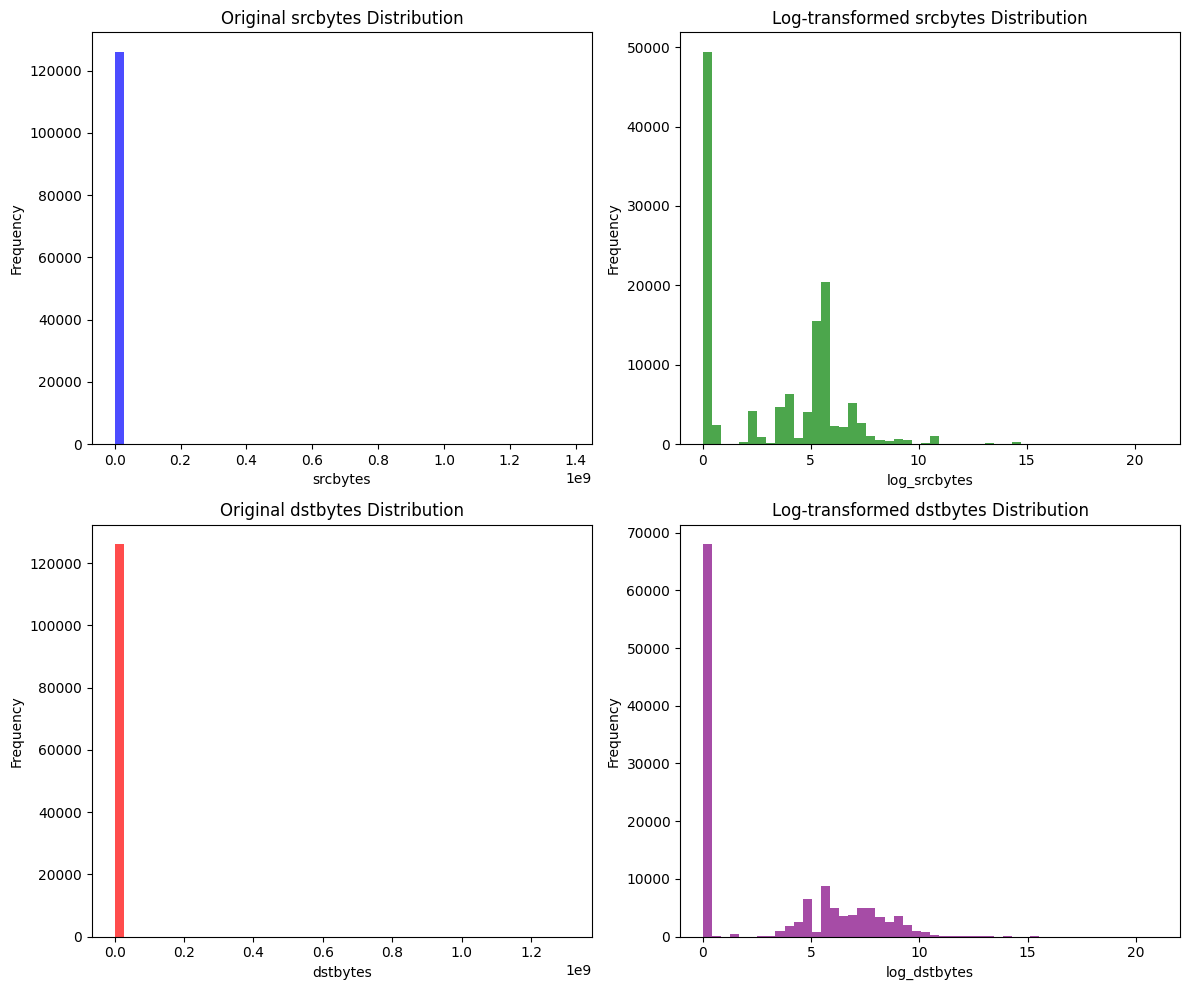

In [107]:
# Plotting the distribution of the original and log-transformed 'srcbytes' and 'dstbytes'
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original srcbytes distribution
axes[0, 0].hist(encoded_data_numeric['srcbytes'], bins=50, color='blue', alpha=0.7)
axes[0, 0].set_title('Original srcbytes Distribution')
axes[0, 0].set_xlabel('srcbytes')
axes[0, 0].set_ylabel('Frequency')

# Log-transformed srcbytes distribution
axes[0, 1].hist(encoded_data_numeric['log_srcbytes'], bins=50, color='green', alpha=0.7)
axes[0, 1].set_title('Log-transformed srcbytes Distribution')
axes[0, 1].set_xlabel('log_srcbytes')
axes[0, 1].set_ylabel('Frequency')

# Original dstbytes distribution
axes[1, 0].hist(encoded_data_numeric['dstbytes'], bins=50, color='red', alpha=0.7)
axes[1, 0].set_title('Original dstbytes Distribution')
axes[1, 0].set_xlabel('dstbytes')
axes[1, 0].set_ylabel('Frequency')

# Log-transformed dstbytes distribution
axes[1, 1].hist(encoded_data_numeric['log_dstbytes'], bins=50, color='purple', alpha=0.7)
axes[1, 1].set_title('Log-transformed dstbytes Distribution')
axes[1, 1].set_xlabel('log_dstbytes')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [108]:
# Drop the original 'srcbytes' and 'dstbytes' columns
encoded_data_numeric.drop(['srcbytes', 'dstbytes'], axis=1, inplace=True)

## dropping the 'numoutboundcmds' and 'ishostlogin' columns

In [109]:
encoded_data_numeric['numoutboundcmds'].value_counts()

,count
numoutboundcmds,
0,125973


In [110]:
encoded_data_numeric.drop(columns=['numoutboundcmds'], inplace=True)

In [111]:
encoded_data_numeric['ishostlogin'].value_counts()

,count
ishostlogin,
0,125972
1,1


In [112]:
encoded_data_numeric.drop(columns=['ishostlogin'], inplace=True)

## label encoding the the target variable i.e. the 'attack' column

In [113]:
class_mapping = {
    'normal': 'Normal Traffic',
    'neptune': 'DoS',
    'smurf': 'DoS',
    'back': 'DoS',
    'teardrop': 'DoS',
    'pod': 'DoS',
    'land': 'DoS',
    'satan': 'Probe',
    'ipsweep': 'Probe',
    'portsweep': 'Probe',
    'nmap': 'Probe',
    'warezclient': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'ftp_write': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'warezmaster': 'R2L',
    'spy': 'R2L',
    'buffer_overflow': 'U2R',
    'rootkit': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R'
}

In [114]:
# Apply the mapping to the 'attack' column to create the new class groups
encoded_data_numeric['attack_group'] = encoded_data_numeric['attack'].map(class_mapping)


# Initialize the label encoder for the new attack groups
label_encoder = LabelEncoder()

# Encode the new attack groups
encoded_data_numeric['attack_group_encoded'] = label_encoder.fit_transform(encoded_data_numeric['attack_group'])

# Check the mapping of new classes to labels
new_class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
new_class_mapping, encoded_data_numeric[['attack', 'attack_group', 'attack_group_encoded']].head()

({'DoS': 0, 'Normal Traffic': 1, 'Probe': 2, 'R2L': 3, 'U2R': 4},
     attack    attack_group  attack_group_encoded
 0   normal  Normal Traffic                     1
 1   normal  Normal Traffic                     1
 2  neptune             DoS                     0
 3   normal  Normal Traffic                     1
 4   normal  Normal Traffic                     1)

In [115]:
encoded_data_numeric.drop(columns=['attack', 'attack_group'], inplace=True)

## Split the Data

In [116]:
from sklearn.model_selection import train_test_split

# Features and target variable
X = encoded_data_numeric.drop(columns=['attack_group_encoded'])
y = encoded_data_numeric['attack_group_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [90]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((100778, 122), (25195, 122), (100778,), (25195,))

## Random forest classifier to acertain feature importance

#### Train and evaluate the Random Forest Classifier

In [135]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, roc_auc_score, classification_report

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': [200, 700, 800, 1000, 1200],
    'max_depth': [15, 20, 25, 30, 35, 50],
    'min_samples_split': [2, 3, 5, 8],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define multiple scorers using built-in metrics
scorers = {
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'roc_auc': make_scorer(roc_auc_score, multi_class='ovo', average='macro')
}

# Setup RandomizedSearchCV with multiple scorers
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings sampled
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,  # Detailed logging
    random_state=42,  # For reproducibility
    scoring=scorers,  # Use multiple scorers
    refit='f1'  # Choose the metric to refit the model on
)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters found:", random_search.best_params_)

# Use the best model
best_rf = random_search.best_estimator_

# Evaluate the model
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'n_estimators': 1200, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9186
           1       1.00      1.00      1.00     13469
           2       1.00      1.00      1.00      2331
           3       0.99      0.99      0.99       199
           4       0.91      1.00      0.95        10

    accuracy                           1.00     25195
   macro avg       0.98      1.00      0.99     25195
weighted avg       1.00      1.00      1.00     25195



**Insights:**
- Class 0 (Normal Traffic), Class 1 (DoS), Class 2 (Probe): These classes show perfect precision, recall, and F1-scores, indicating that the model is highly accurate in predicting these classes without misclassification.

- Class 3 (R2L): This class also has very high metrics, demonstrating that the model effectively identifies R2L attacks with minimal error.

- Class 4 (U2R): Although this class has slightly lower precision and recall, the results are still very high. Given the low support (only 10 instances), minor fluctuations in performance metrics can occur due to class imbalance.

Accuracy: An overall accuracy of 1.00 suggests that almost all predictions made by the model are correct, which is indicative of a well-fitted model for this dataset.

In [136]:
from sklearn.metrics import classification_report, confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[ 9186     0     0     0     0]
 [    2 13463     1     2     1]
 [    0     3  2328     0     0]
 [    0     2     0   197     0]
 [    0     0     0     0    10]]


#### Saving Model and Components

In [137]:
import joblib

# Save the trained model
model_path = '/content/drive/MyDrive/Portfolio Project/random_forest_model.pkl'
joblib.dump(best_rf, model_path)

# Save the label encoder
label_encoder_path = '/content/drive/MyDrive/Portfolio Project/label_encoder.pkl'
joblib.dump(label_encoder, label_encoder_path)

# Save the scaler
scaler_path = '/content/drive/MyDrive/Portfolio Project/scaler.pkl'
joblib.dump(scaler, scaler_path)

# Save the feature names (optional)
feature_names_path = '/content/drive/MyDrive/Portfolio Project/feature_names.pkl'
joblib.dump(X.columns.tolist(), feature_names_path)

['/content/drive/MyDrive/Portfolio Project/feature_names.pkl']

#### Feature Importance

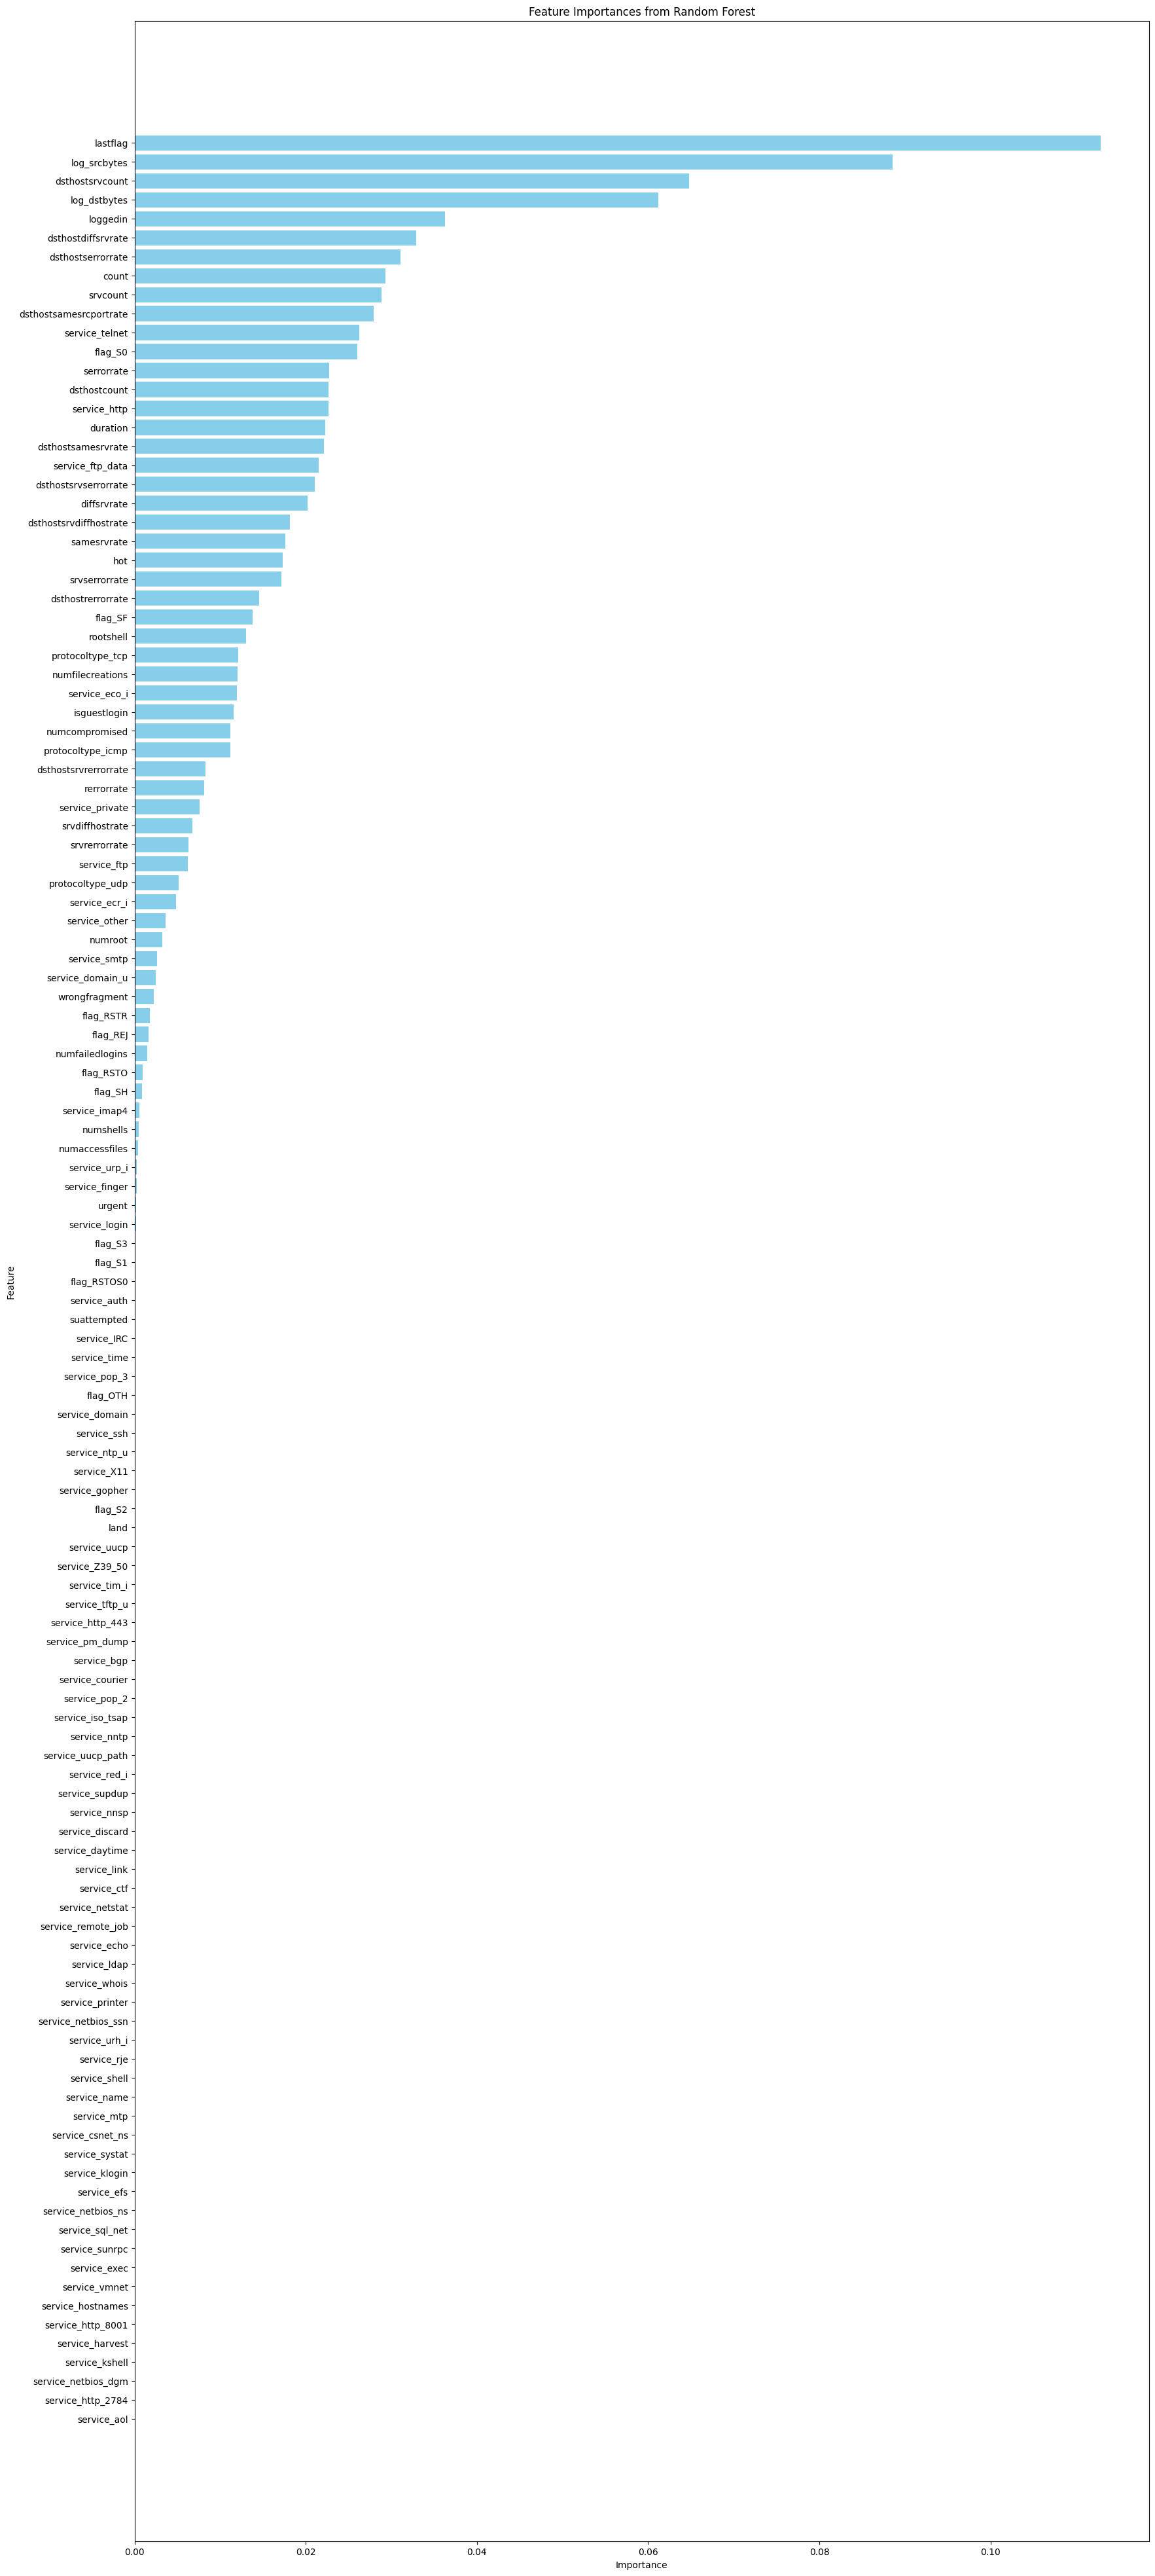

In [140]:
# Get feature importances from the best model
importances = best_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


# Plot the feature importances
plt.figure(figsize=(20, 50))  # Adjust the figure size as needed
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()
